In [1]:


from pathlib import Path
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


In [2]:
symbol = "BTCUSDT"
if Path("Users").exists():  # Windows
    input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500\VPIN"
    file_path = rf"{input_path}\{symbol}.csv"
else:  # Macbook
    input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500/VPIN"
    file_path = f"{input_path}/{symbol}.csv"

data = pd.read_csv(file_path, parse_dates=['Time'])

data = data.drop(columns=["Unnamed: 0"], errors='ignore')
data.drop("KyleLambda", axis=1, inplace=True, errors='ignore')

In [3]:
FLASH_CRASH_TIME_STR = "2025-10-10 21:15:40"  # TODO: sửa timestamp flash crash

In [4]:
# Chuyển cột Time về datetime (nếu chưa)
df = data.copy()
df["Time"] = pd.to_datetime(df["Time"])

# Chỉ lấy các cột cần thiết cho bài toán
cols_needed = [
    "Price",
    "Time",
    "VPIN",
    "CDF",
    "RealizedVolatility",
    "BidAskSpread",
    "Volume",
    "AmihudLambda",
    "Returns",
]
missing_cols = [c for c in cols_needed if c not in df.columns]
if missing_cols:
    raise ValueError(f"Các cột thiếu trong data: {missing_cols}")

df = df[cols_needed].copy()


In [5]:
# Loại bỏ các dòng NaN trong các biến dùng cho mô hình
feature_cols = [
    "VPIN",
    "CDF",
    "RealizedVolatility",
    "BidAskSpread",
    "Volume",
    "AmihudLambda",
]

In [6]:
df_model = df.dropna(subset=feature_cols).copy()
print("Số quan sát dùng cho mô hình:", len(df_model))

Số quan sát dùng cho mô hình: 2115


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[feature_cols])

In [8]:
# Chạy k-means với 3 cụm (3 chế độ)
kmeans = KMeans(
    n_clusters=3,
    n_init=50,       # nhiều lần khởi tạo để ổn định
    random_state=42,
)
df_model["RegimeRaw"] = kmeans.fit_predict(X_scaled)

In [9]:
cdf_means = df_model.groupby("RegimeRaw")["CDF"].mean().sort_values()

In [10]:
# Sắp xếp theo CDF tăng dần -> gán 1,2,3
ordered_clusters = list(cdf_means.index)  # ví dụ [2, 0, 1]
cluster_to_regime = {cluster_id: regime_id + 1
                     for regime_id, cluster_id in enumerate(ordered_clusters)}
cluster_to_regime

{1: 1, 2: 2, 0: 3}

In [11]:

df_model["Regime"] = df_model["RegimeRaw"].map(cluster_to_regime)

In [12]:
# Gán tên chế độ
regime_name_map = {
    1: "Normal Liquidity",
    2: "Stressed Liquidity",
    3: "Extreme Toxicity",
}
df_model["RegimeName"] = df_model["Regime"].map(regime_name_map)

In [13]:
# Merge kết quả regime ngược lại vào df gốc (nếu cần giữ đầy đủ dòng)
df = df.merge(
    df_model[["Time", "Regime", "RegimeName"]],
    on="Time",
    how="left"
)

In [14]:
print("Gán chế độ thị trường xong. Các chế độ:")
print(df_model["RegimeName"].value_counts())
print()


Gán chế độ thị trường xong. Các chế độ:
RegimeName
Extreme Toxicity      1083
Stressed Liquidity     967
Normal Liquidity        65
Name: count, dtype: int64



In [15]:
# ============================================================
# 5. THỐNG KÊ ĐẶC TRƯNG THEO TỪNG REGIME
# ============================================================

summary = (
    df_model
    .groupby("RegimeName")
    .agg(
        VPIN_mean=("VPIN", "mean"),
        VPIN_std=("VPIN", "std"),
        CDF_mean=("CDF", "mean"),
        CDF_std=("CDF", "std"),
        Vol_mean=("RealizedVolatility", "mean"),
        Spread_mean=("BidAskSpread", "mean"),
        Volume_mean=("Volume", "mean"),
        Illiquidity_mean=("AmihudLambda", "mean"),
        Ret_mean=("Returns", "mean"),
        Ret_std=("Returns", "std"),
        Count=("Returns", "count"),
    )
    .sort_values("CDF_mean")
)


In [16]:
print("===== Thống kê theo từng Regime =====")
print(summary)
print()


===== Thống kê theo từng Regime =====
                    VPIN_mean  VPIN_std  CDF_mean   CDF_std  Vol_mean  \
RegimeName                                                              
Normal Liquidity     0.130031  0.023866  0.119878  0.140769  0.007076   
Stressed Liquidity   0.152424  0.015804  0.253050  0.138011  0.002058   
Extreme Toxicity     0.186986  0.014150  0.743573  0.148938  0.001945   

                    Spread_mean  Volume_mean  Illiquidity_mean  Ret_mean  \
RegimeName                                                                 
Normal Liquidity    -136.941973        341.0      2.846396e+06  0.000405   
Stressed Liquidity   -10.714255        341.0      9.878461e+06 -0.000026   
Extreme Toxicity     -10.954579        341.0      1.048214e+07 -0.000046   

                     Ret_std  Count  
RegimeName                           
Normal Liquidity    0.006537     65  
Stressed Liquidity  0.002141    967  
Extreme Toxicity    0.002148   1083  



In [17]:
# ============================================================
# 6. KIỂM TRA REGIME TẠI THỜI ĐIỂM FLASH CRASH
# ============================================================
FLASH_CRASH_TIME_STR = "2025-10-10 21:20:23"
flash_crash_time = pd.to_datetime(FLASH_CRASH_TIME_STR).tz_localize("UTC")


# Tìm dòng gần flash crash nhất
idx_nearest = (df["Time"] - flash_crash_time).abs().idxmin()
row_flash = df.loc[idx_nearest]

print("===== Thông tin tại (hoặc gần) thời điểm Flash Crash =====")
print("Time:       ", row_flash["Time"])
print("Regime:     ", int(row_flash["Regime"]))
print("RegimeName: ", row_flash["RegimeName"])
print("VPIN:       ", row_flash["VPIN"])
print("CDF:        ", row_flash["CDF"])
print("Returns:    ", row_flash["Returns"])
print("RealizedVol:", row_flash["RealizedVolatility"])
print("BidAskSpread:", row_flash["BidAskSpread"])
print()

===== Thông tin tại (hoặc gần) thời điểm Flash Crash =====
Time:        2025-10-10 21:20:23+00:00
Regime:      1
RegimeName:  Normal Liquidity
VPIN:        0.1634664791558698
CDF:         0.3563327032136106
Returns:     -0.004831002169908
RealizedVol: 0.006980748285825
BidAskSpread: -70.35697453129978



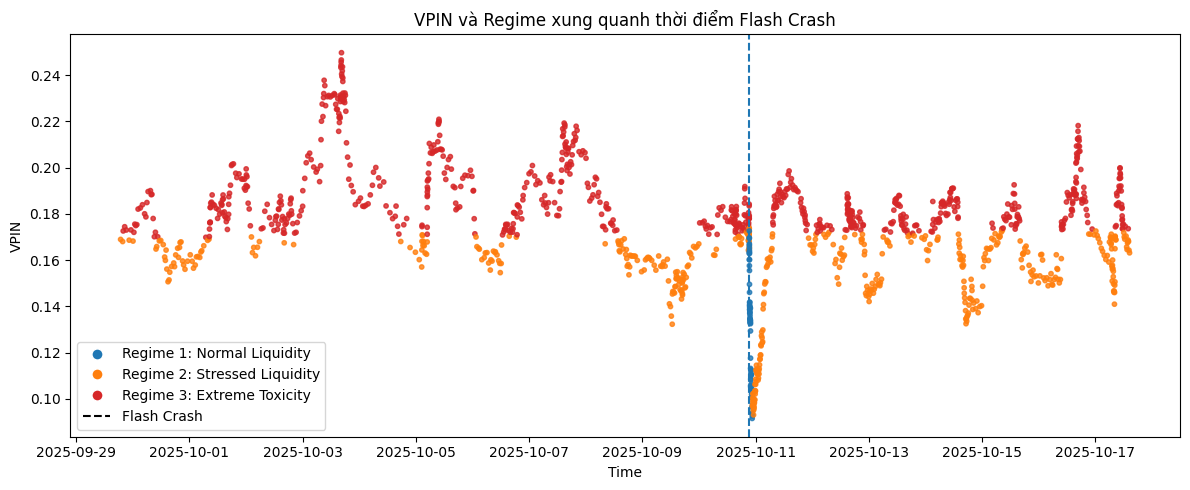

In [18]:
# ============================================================
# 7. VẼ BIỂU ĐỒ: VPIN + REGIME + FLASH CRASH
# ============================================================

# Để plot cho gọn, có thể chọn window xung quanh flash crash
window_minutes = 16000  # ví dụ 60 phút xung quanh flash crash
time_min = flash_crash_time - pd.Timedelta(minutes=window_minutes)
time_max = flash_crash_time + pd.Timedelta(minutes=window_minutes)

df_window = df[(df["Time"] >= time_min) &
                     (df["Time"] <= time_max)].copy()

# Map regime -> số để tô màu
color_map = {1: "tab:blue", 2: "tab:orange", 3: "tab:red"}
colors = df_window["Regime"].map(color_map)

plt.figure(figsize=(12, 5))
plt.scatter(df_window["Time"], df_window["VPIN"], c=colors, s=10, alpha=0.8)
plt.axvline(flash_crash_time, linestyle="--", linewidth=1.5, label="Flash Crash")

plt.title("VPIN và Regime xung quanh thời điểm Flash Crash")
plt.xlabel("Time")
plt.ylabel("VPIN")
# Tạo legend cho các regime
handles = []
for reg_id, name in regime_name_map.items():
    handles.append(
        plt.Line2D(
            [0], [0],
            marker="o",
            color="w",
            label=f"Regime {reg_id}: {name}",
            markerfacecolor=color_map[reg_id],
            markersize=8
        )
    )
plt.legend(handles=handles + [plt.Line2D([0], [0], color="k", linestyle="--", label="Flash Crash")])
plt.tight_layout()
plt.show()


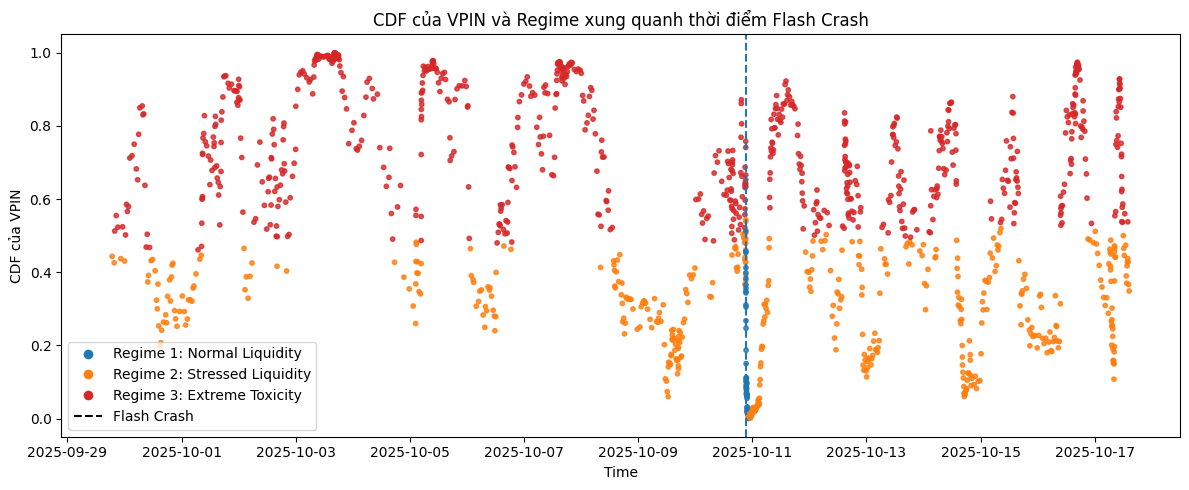

In [20]:
# ============================================================
# 7. VẼ BIỂU ĐỒ: CDF của VPIN + REGIME + FLASH CRASH
# ============================================================

# Để plot cho gọn, có thể chọn window xung quanh flash crash
window_minutes = 16000  # ví dụ 60 phút xung quanh flash crash
time_min = flash_crash_time - pd.Timedelta(minutes=window_minutes)
time_max = flash_crash_time + pd.Timedelta(minutes=window_minutes)

df_window = df[(df["Time"] >= time_min) &
                     (df["Time"] <= time_max)].copy()

# Map regime -> số để tô màu
color_map = {1: "tab:blue", 2: "tab:orange", 3: "tab:red"}
colors = df_window["Regime"].map(color_map)

plt.figure(figsize=(12, 5))
plt.scatter(df_window["Time"], df_window["CDF"], c=colors, s=10, alpha=0.8)
plt.axvline(flash_crash_time, linestyle="--", linewidth=1.5, label="Flash Crash")

plt.title("CDF của VPIN và Regime xung quanh thời điểm Flash Crash")
plt.xlabel("Time")
plt.ylabel("CDF của VPIN")
# Tạo legend cho các regime
handles = []
for reg_id, name in regime_name_map.items():
    handles.append(
        plt.Line2D(
            [0], [0],
            marker="o",
            color="w",
            label=f"Regime {reg_id}: {name}",
            markerfacecolor=color_map[reg_id],
            markersize=8
        )
    )
plt.legend(handles=handles + [plt.Line2D([0], [0], color="k", linestyle="--", label="Flash Crash")])
plt.tight_layout()
plt.show()


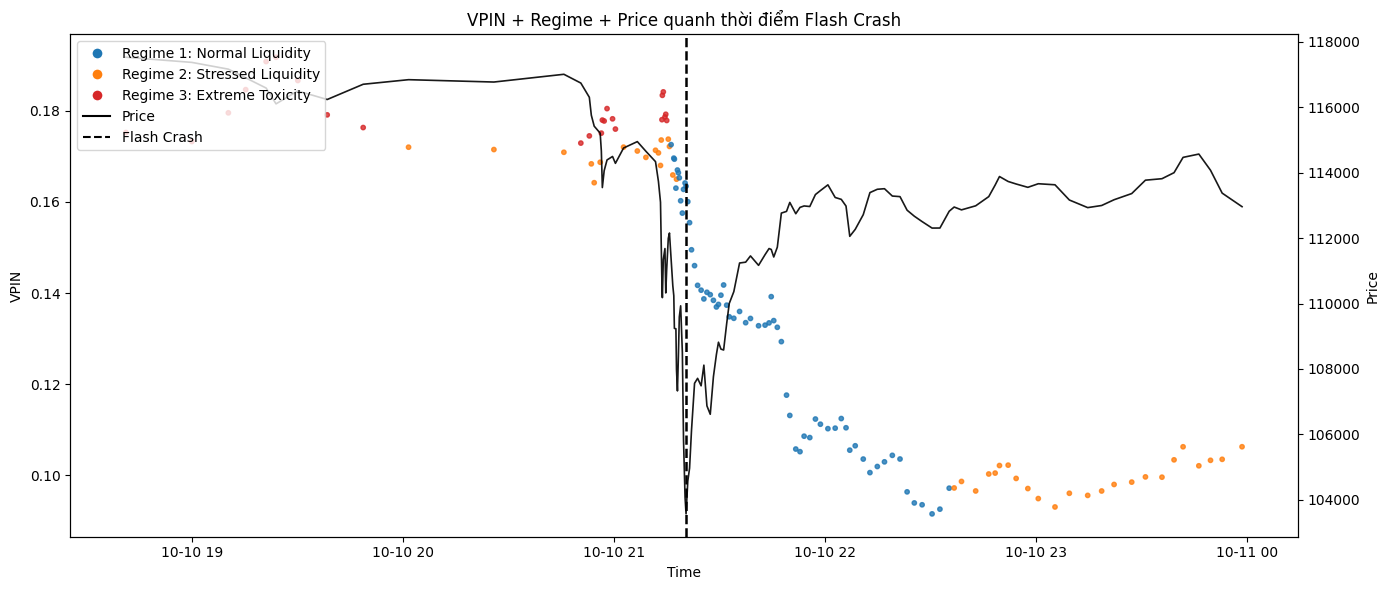

In [ ]:
# ============================================================
# 7. VẼ BIỂU ĐỒ: VPIN + PRICE + REGIME + FLASH CRASH
# ============================================================

# Chọn cửa sổ thời gian quanh flash crash
window_minutes = 160
time_min = flash_crash_time - pd.Timedelta(minutes=window_minutes)
time_max = flash_crash_time + pd.Timedelta(minutes=window_minutes)

df_window = df_model[(df_model["Time"] >= time_min) &
                     (df_model["Time"] <= time_max)].copy()

# Map regime -> màu
color_map = {1: "tab:blue", 2: "tab:orange", 3: "tab:red"}
colors = df_window["Regime"].map(color_map)

plt.figure(figsize=(14, 6))

# --- TRỤC VPIN ---
ax1 = plt.gca()
ax1.scatter(df_window["Time"], df_window["VPIN"], c=colors, s=10, alpha=0.8, label="VPIN")
ax1.set_xlabel("Time")
ax1.set_ylabel("VPIN")

# --- TRỤC PRICE ---
ax2 = ax1.twinx()
ax2.plot(df_window["Time"], df_window["Price"], linewidth=1.2, alpha=0.9, label="Price", color="black")
ax2.set_ylabel("Price")

# Đường Flash Crash
ax1.axvline(flash_crash_time, linestyle="--", linewidth=1.8, color="k")

plt.title("VPIN + Regime + Price quanh thời điểm Flash Crash")

# Legend cho Regime
handles = []
for reg_id, name in regime_name_map.items():
    handles.append(
        plt.Line2D([0], [0],
                   marker="o", color="w",
                   markerfacecolor=color_map[reg_id],
                   markersize=8,
                   label=f"Regime {reg_id}: {name}")
    )

# thêm đường price + flash crash vào legend
handles.append(plt.Line2D([0], [0], color="black", label="Price"))
handles.append(plt.Line2D([0], [0], color="k", linestyle="--", label="Flash Crash"))

plt.legend(handles=handles, loc="upper left")

plt.tight_layout()
plt.show()


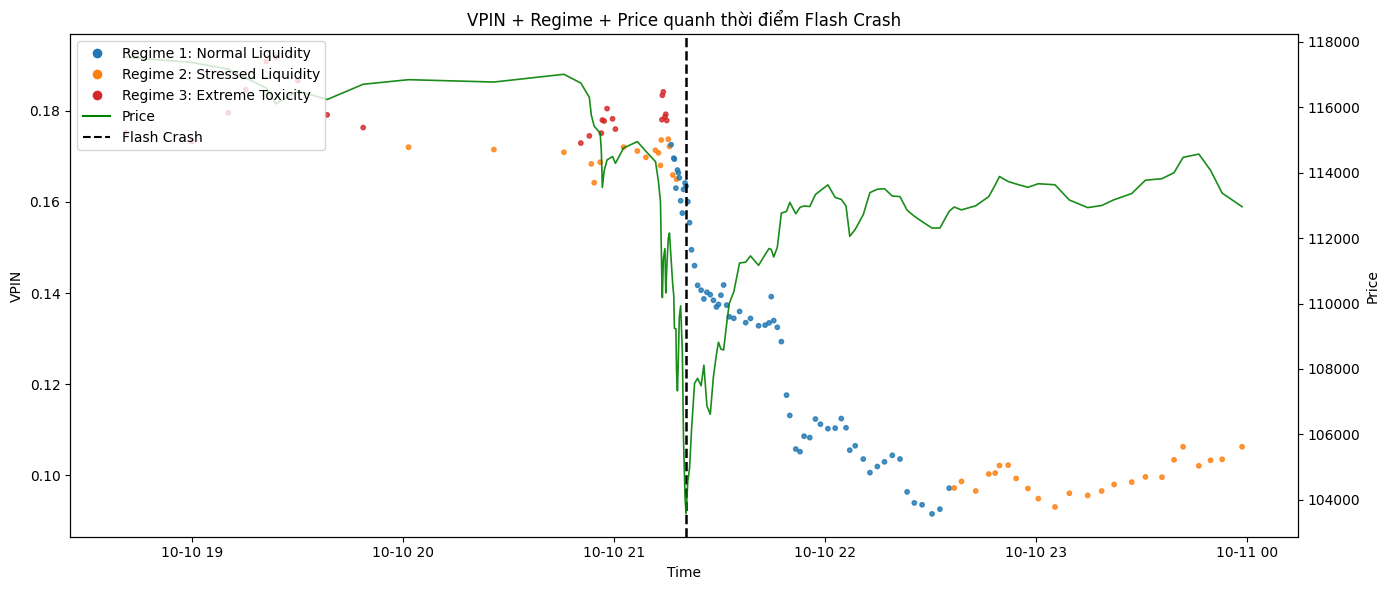

In [ ]:
# ============================================================
# 7. VẼ BIỂU ĐỒ: VPIN + PRICE + REGIME + FLASH CRASH
# ============================================================

# Chọn cửa sổ thời gian quanh flash crash
window_minutes = 160
time_min = flash_crash_time - pd.Timedelta(minutes=window_minutes)
time_max = flash_crash_time + pd.Timedelta(minutes=window_minutes)

df_window = df_model[(df_model["Time"] >= time_min) &
                     (df_model["Time"] <= time_max)].copy()

# Map regime -> màu
color_map = {1: "tab:blue", 2: "tab:orange", 3: "tab:red"}
colors = df_window["Regime"].map(color_map)

plt.figure(figsize=(14, 6))

# --- TRỤC VPIN ---
ax1 = plt.gca()
ax1.scatter(df_window["Time"], df_window["VPIN"], c=colors, s=10, alpha=0.8, label="VPIN")
ax1.set_xlabel("Time")
ax1.set_ylabel("VPIN")

# --- TRỤC PRICE ---
ax2 = ax1.twinx()
ax2.plot(df_window["Time"], df_window["Price"], linewidth=1.2, alpha=0.9, label="Price", color="green")
ax2.set_ylabel("Price")

# Đường Flash Crash
ax1.axvline(flash_crash_time, linestyle="--", linewidth=1.8, color="k")

plt.title("VPIN + Regime + Price quanh thời điểm Flash Crash")

# Legend cho Regime
handles = []
for reg_id, name in regime_name_map.items():
    handles.append(
        plt.Line2D([0], [0],
                   marker="o", color="w",
                   markerfacecolor=color_map[reg_id],
                   markersize=8,
                   label=f"Regime {reg_id}: {name}")
    )

# thêm đường price + flash crash vào legend
handles.append(plt.Line2D([0], [0], color="green", label="Price"))
handles.append(plt.Line2D([0], [0], color="k", linestyle="--", label="Flash Crash"))

plt.legend(handles=handles, loc="upper left")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import pandas as pd
import numpy as np

# ============================================================
# 1. CHUẨN BỊ DỮ LIỆU
# ============================================================

df = data.copy()
df["Time"] = pd.to_datetime(df["Time"])

feature_cols = [
    "VPIN",
    "CDF",
    "RealizedVolatility",
    "BidAskSpread",
    "Volume",
    "AmihudLambda",
]

df_model = df.dropna(subset=feature_cols).copy()

# ============================================================
# 2. STANDARDIZE FEATURES
# ============================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[feature_cols])

# ============================================================
# 3. PCA (giảm nhiễu, giữ cấu trúc chính)
# ============================================================

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Giải thích phương sai PCA:", pca.explained_variance_ratio_.sum())

# ============================================================
# 4. GAUSSIAN MIXTURE MODEL (GMM)
# ============================================================

gmm = GaussianMixture(
    n_components=3,
    covariance_type="full",
    n_init=20,
    random_state=42
)
df_model["RegimeRaw"] = gmm.fit_predict(X_pca)

# ============================================================
# 5. REORDER REGIME THEO MỨC ĐỘ RỦI RO
# ------------------------------------------------------------
# Định nghĩa RiskScore = combination of VPIN + Vol + Spread
# ============================================================

risk_score = (
    0.5 * df_model["VPIN"]
    + 0.3 * df_model["RealizedVolatility"]
    + 0.2 * df_model["BidAskSpread"]
)

df_model["RiskScore"] = risk_score
# ... giữ nguyên phần đến df_model["RiskScore"] = risk_score

# ❌ BỎ DÒNG NÀY:
# df_model["Regime"] = pd.qcut(df_model["RiskScore"], q=3, labels=[1,2,3])

# Mean RiskScore theo từng cụm GMM
risk_means = df_model.groupby("RegimeRaw")["RiskScore"].mean().sort_values()

# Thứ tự cụm theo risk tăng dần -> 1,2,3
ordered_clusters = list(risk_means.index)

cluster_to_regime = {
    cluster_id: regime_id + 1
    for regime_id, cluster_id in enumerate(ordered_clusters)
}

df_model["Regime"] = df_model["RegimeRaw"].map(cluster_to_regime)

print("Regime counts:")
print(df_model["Regime"].value_counts())


Giải thích phương sai PCA: 0.7997640840459832
Regime counts:
Regime
2    1123
3     919
1      73
Name: count, dtype: int64


In [ ]:
i = (df_model["Time"] - flash_crash_time).abs().argmin()
df_model.iloc[i][["Time", "VPIN", "RiskScore", "Regime"]]


Time         2025-10-10 21:20:23+00:00
VPIN                          0.163466
RiskScore                   -13.987567
Regime                               1
Name: 1495, dtype: object

In [ ]:
df = data.copy()
df["Time"] = pd.to_datetime(df["Time"])

feature_cols = [
    "VPIN",
    "CDF",
    "RealizedVolatility",
    "BidAskSpread",
    "Volume",
    "AmihudLambda",
]

df_model = df.dropna(subset=feature_cols).copy()

risk_score = (
    0.5 * df_model["VPIN"]
    + 0.3 * df_model["RealizedVolatility"]
    + 0.2 * df_model["BidAskSpread"]
)
df_model["RiskScore"] = risk_score

df_model["Regime"] = pd.qcut(df_model["RiskScore"], q=3, labels=[1,2,3])

print(df_model["Regime"].value_counts())


Regime
1    705
2    705
3    705
Name: count, dtype: int64


In [ ]:
i = (df_model["Time"] - flash_crash_time).abs().argmin()
print(df_model.iloc[i][["Time", "VPIN", "RiskScore", "Regime"]])


Time         2025-10-10 21:20:23+00:00
VPIN                          0.163466
RiskScore                   -13.987567
Regime                               1
Name: 1495, dtype: object


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Giả sử df đã tồn tại, có cột Time, VPIN, CDF
df = df.copy()
df["Time"] = pd.to_datetime(df["Time"])
df = df.sort_values("Time").reset_index(drop=True)

# Thời điểm flash crash (đã xác định trước đó)
# ví dụ:
# flash_crash_time = pd.Timestamp("2025-10-10 21:20:23+00:00")

# Chỉ dùng dữ liệu trước crash để xác định ngưỡng "bình thường"
df_pre = df[df["Time"] < flash_crash_time]

# Chọn ngưỡng theo quantile của CDF(VPIN)
q = 0.70
cdf_threshold = df_pre["CDF"].quantile(q)

print(f"Ngưỡng cảnh báo CDF(VPIN) (q={q}):", cdf_threshold)


Ngưỡng cảnh báo CDF(VPIN) (q=0.7): 0.7218809073724007


In [ ]:
# Tín hiệu cảnh báo: CDF(VPIN) vượt ngưỡng
df["alert"] = (df["CDF"] >= cdf_threshold).astype(int)

# Chỉ xét tín hiệu trước flash crash
df_before_crash = df[df["Time"] <= flash_crash_time].copy()

# Thời điểm cảnh báo đầu tiên trước crash
alerts_before = df_before_crash[df_before_crash["alert"] == 1]

if len(alerts_before) == 0:
    print("Không có cảnh báo nào trước flash crash với ngưỡng này.")
else:
    first_alert_time = alerts_before["Time"].iloc[0]
    lead_time = flash_crash_time - first_alert_time
    print("Thời điểm cảnh báo đầu tiên:", first_alert_time)
    print("Flash crash xảy ra tại:", flash_crash_time)
    print("Lead time (cảnh báo sớm trước crash):", lead_time)


Thời điểm cảnh báo đầu tiên: 2025-09-07 13:15:13+00:00
Flash crash xảy ra tại: 2025-10-10 21:20:23+00:00
Lead time (cảnh báo sớm trước crash): 33 days 08:05:10


In [ ]:
# Gộp các alert liên tiếp thành từng "episode"
df["alert_start"] = (df["alert"].diff().fillna(0) == 1)

# Gán id cho mỗi episode
episode_id = (df["alert_start"]).cumsum()
df["alert_episode_id"] = np.where(df["alert"] == 1, episode_id, np.nan)

# Lấy thông tin từng episode
episodes = (
    df[df["alert"] == 1]
    .groupby("alert_episode_id")
    .agg(
        start_time=("Time", "min"),
        end_time=("Time", "max"),
    )
    .reset_index(drop=True)
)

# Đánh dấu episode nào "dẫn tới crash" trong 60 phút
danger_window = pd.Timedelta(minutes=60)

def leads_to_crash(row):
    return (row["start_time"] <= flash_crash_time <= row["start_time"] + danger_window)

episodes["leads_to_crash"] = episodes.apply(leads_to_crash, axis=1)

n_episodes = len(episodes)
n_true_alarm = episodes["leads_to_crash"].sum()
n_false_alarm = n_episodes - n_true_alarm

print("Số episode cảnh báo:", n_episodes)
print("Episode dẫn tới flash crash:", n_true_alarm)
print("Episode cảnh báo sai (false alarm):", n_false_alarm)
print(episodes)


Số episode cảnh báo: 63
Episode dẫn tới flash crash: 1
Episode cảnh báo sai (false alarm): 62
                  start_time                  end_time  leads_to_crash
0  2025-09-07 13:15:13+00:00 2025-09-07 14:32:03+00:00           False
1  2025-09-07 17:30:11+00:00 2025-09-08 01:08:26+00:00           False
2  2025-09-08 20:37:39+00:00 2025-09-09 01:03:56+00:00           False
3  2025-09-10 09:36:11+00:00 2025-09-10 09:36:11+00:00           False
4  2025-09-10 12:30:06+00:00 2025-09-12 05:37:07+00:00           False
..                       ...                       ...             ...
58 2025-10-15 15:26:42+00:00 2025-10-15 15:26:42+00:00           False
59 2025-10-16 11:41:15+00:00 2025-10-16 13:20:02+00:00           False
60 2025-10-16 14:17:47+00:00 2025-10-16 19:47:55+00:00           False
61 2025-10-17 08:52:18+00:00 2025-10-17 11:03:41+00:00           False
62 2025-10-17 11:14:37+00:00 2025-10-17 11:14:37+00:00           False

[63 rows x 3 columns]


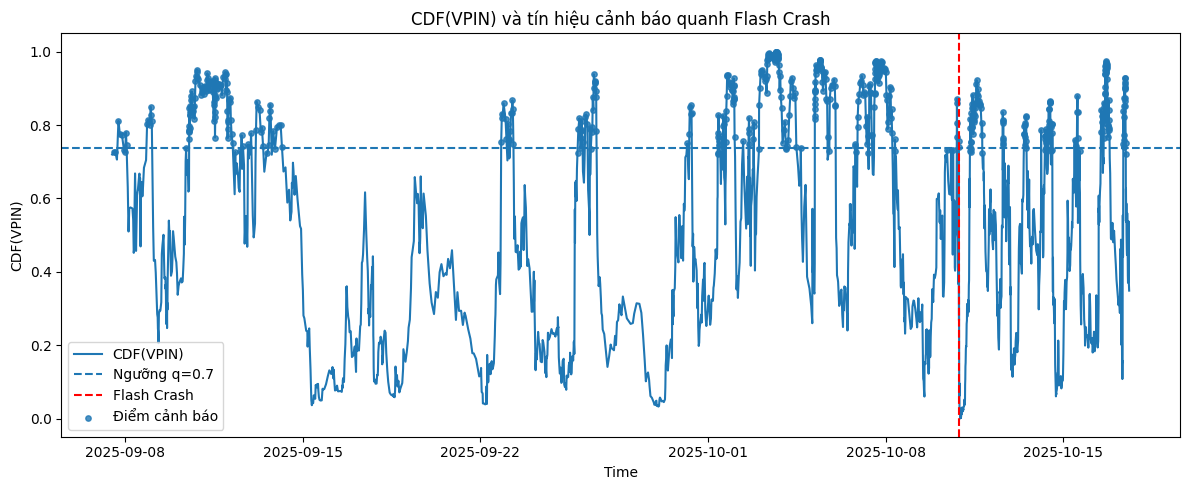

In [ ]:
window_minutes = 160
# time_min = flash_crash_time - pd.Timedelta(minutes=window_minutes)
# time_max = flash_crash_time + pd.Timedelta(minutes=window_minutes)
time_min = df["Time"].min()
time_max = df["Time"].max()
df_win = df[(df["Time"] >= time_min) & (df["Time"] <= time_max)].copy()

plt.figure(figsize=(12, 5))
plt.plot(df_win["Time"], df_win["CDF"], label="CDF(VPIN)")
plt.axhline(cdf_threshold, linestyle="--", label=f"Ngưỡng q={q}")
plt.axvline(flash_crash_time, color="red", linestyle="--", label="Flash Crash")

# Tô đậm vùng alert
mask_alert = df_win["alert"] == 1
plt.scatter(df_win.loc[mask_alert, "Time"],
            df_win.loc[mask_alert, "CDF"],
            s=15, alpha=0.8, label="Điểm cảnh báo")

plt.title("CDF(VPIN) và tín hiệu cảnh báo quanh Flash Crash")
plt.xlabel("Time")
plt.ylabel("CDF(VPIN)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
lookback = flash_crash_time - pd.Timedelta(hours=24)
df_lookback = df[(df["Time"] >= lookback) & (df["Time"] < flash_crash_time)]

cdf_threshold = df_lookback["CDF"].quantile(0.95)  # đuôi của 24h lookback


Ngưỡng cảnh báo CDF(VPIN) (q=0.8): 0.8284


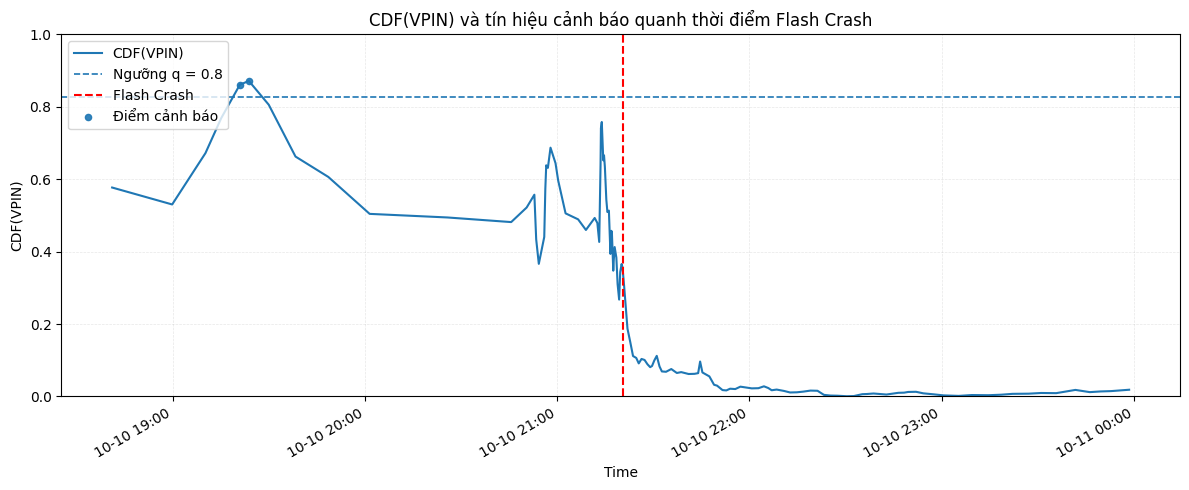

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ============================================
# 0. Chuẩn bị dữ liệu
# ============================================
df_plot = df.copy()
df_plot["Time"] = pd.to_datetime(df_plot["Time"])
df_plot = df_plot.sort_values("Time").reset_index(drop=True)

# Chỉ dùng dữ liệu trước flash crash để tính ngưỡng
df_pre = df_plot[df_plot["Time"] < flash_crash_time].copy()

# ============================================
# 1. Chọn ngưỡng cảnh báo q = 0.8
# ============================================
q = 0.80
cdf_threshold = df_pre["CDF"].quantile(q)
print(f"Ngưỡng cảnh báo CDF(VPIN) (q={q}): {cdf_threshold:.4f}")

# Tạo cột tín hiệu cảnh báo
df_plot["alert"] = (df_plot["CDF"] >= cdf_threshold).astype(int)

# ============================================
# 2. Chọn cửa sổ thời gian quanh flash crash để vẽ
# ============================================
window_minutes = 160  # tùy chỉnh: 60, 120, 160,...
time_min = flash_crash_time - pd.Timedelta(minutes=window_minutes)
time_max = flash_crash_time + pd.Timedelta(minutes=window_minutes)

df_win = df_plot[(df_plot["Time"] >= time_min) & (df_plot["Time"] <= time_max)].copy()

# ============================================
# 3. Vẽ biểu đồ
# ============================================
plt.figure(figsize=(12, 5))

# Đường CDF(VPIN)
plt.plot(df_win["Time"], df_win["CDF"],
         linewidth=1.5, label="CDF(VPIN)")

# Đường ngưỡng q = 0.8
plt.axhline(cdf_threshold, color="tab:blue", linestyle="--",
            linewidth=1.2, label=f"Ngưỡng q = {q}")

# Đường thời điểm Flash Crash
plt.axvline(flash_crash_time, color="red", linestyle="--",
            linewidth=1.5, label="Flash Crash")

# Các điểm cảnh báo (trước và sau crash đều hiển thị)
mask_alert = df_win["alert"] == 1
plt.scatter(df_win.loc[mask_alert, "Time"],
            df_win.loc[mask_alert, "CDF"],
            s=20, alpha=0.9, label="Điểm cảnh báo")

# Format trục thời gian cho đẹp
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=30, ha="right")

plt.title("CDF(VPIN) và tín hiệu cảnh báo quanh thời điểm Flash Crash")
plt.xlabel("Time")
plt.ylabel("CDF(VPIN)")
plt.ylim(0, 1)          # vì CDF trong [0,1]
plt.grid(alpha=0.3, linestyle="--", linewidth=0.5)
plt.legend(loc="upper left", frameon=True)
plt.tight_layout()

plt.show()


In [ ]:
# ===== 1. Tính lead time của cảnh báo =====
df_alerts = df_plot[(df_plot["Time"] < flash_crash_time) & (df_plot["alert"] == 1)]
first_alert = df_alerts["Time"].min()

lead_time = flash_crash_time - first_alert
print("Thời điểm cảnh báo đầu tiên:", first_alert)
print("Lead time trước flash crash:", lead_time)

# ===== 2. Đếm số episode cảnh báo và false alarms =====
df_plot["alert_start"] = df_plot["alert"].diff().fillna(0) == 1
episode_id = (df_plot["alert_start"]).cumsum()
df_plot["alert_episode"] = np.where(df_plot["alert"] == 1, episode_id, np.nan)

episodes = (
    df_plot[df_plot["alert"] == 1]
    .groupby("alert_episode")
    .agg(start=("Time","min"), end=("Time","max"))
).reset_index(drop=True)

danger_window = pd.Timedelta(minutes=90)

episodes["leads_to_crash"] = episodes["start"].apply(
    lambda t: t <= flash_crash_time <= t + danger_window
)

n_total = len(episodes)
n_true = episodes["leads_to_crash"].sum()
n_false = n_total - n_true

print("Tổng số episode cảnh báo:", n_total)
print("Episode dẫn đến flash crash:", n_true)
print("Episode cảnh báo sai:", n_false)
print(episodes)


Thời điểm cảnh báo đầu tiên: 2025-09-09 00:06:17+00:00
Lead time trước flash crash: 31 days 21:14:06
Tổng số episode cảnh báo: 45
Episode dẫn đến flash crash: 0
Episode cảnh báo sai: 45
                       start                       end  leads_to_crash
0  2025-09-09 00:06:17+00:00 2025-09-09 00:06:17+00:00           False
1  2025-09-10 12:30:23+00:00 2025-09-10 12:30:23+00:00           False
2  2025-09-10 13:26:39+00:00 2025-09-10 16:53:41+00:00           False
3  2025-09-10 18:03:19+00:00 2025-09-11 10:51:28+00:00           False
4  2025-09-11 12:07:23+00:00 2025-09-11 12:36:10+00:00           False
5  2025-09-11 13:20:57+00:00 2025-09-12 00:33:20+00:00           False
6  2025-09-12 02:02:15+00:00 2025-09-12 03:28:29+00:00           False
7  2025-09-13 04:19:02+00:00 2025-09-13 07:05:50+00:00           False
8  2025-09-13 16:49:00+00:00 2025-09-13 17:18:44+00:00           False
9  2025-09-22 20:30:44+00:00 2025-09-22 20:30:44+00:00           False
10 2025-09-22 22:09:30+00:00 2025